In [21]:
import argparse
import copy
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from recsys.shared import sliced_time_list
import pandas as pd
from IPython.display import display

In [22]:
task_list = [
    'user-positive-activity',
    'user-activity',
    'binary-item-rating-std',
    'binary-item-rating-avg',
    'binary-edge-rating',
]

dataset = 'Amazon-Musical_Instruments'

# Results Table

Currently, we have all the data which was generated from all runs of the model. Below we will try to recreate the main table (Table 3) from the paper. We will do this by loading the results of the model and running computation on top of that.

For every model, we have 10 trained models for 10 different seeds. We average the performance number of the model over every timestamp and seed of the model to get a final average performance number for every model.

### Intended task performance
This is the performance of the model on the intended task, i.e the task that the model was trained to perform. Here we compare the degradation in performance of the model as compared to the non-bc model

### Unintended task performance
This is the performance of the model on the unintended task, for which the model was not trained explicitly. Here we compare the degradation in performance of the model as compared to fix-m0 model.

### Function alignment error
This is the function alignment error of the model which is the L2 distance between the embeddings of the model as compared to the fix-m0 approach. This is a proxy for the unintended task performance and we see a high correlation between the two.

Refer to the paper for more details.

In [104]:
lam = 16
label_list = [
    'fix-m0', 
    'finetune-m0',
    'nobc',
     f'posthoc-linear-sloss', 
     f'posthoc-linear-mloss',
     f'joint-notrans-sloss-lam{lam}',
     f'joint-linear-sloss-lam{lam}',
     f'joint-linear-mloss-lam{lam}',
]

def get_df(dataset):
    intended_performance = []

    func_align_error = []
    ref_embedding_list = torch.load(f'embevolve/intended_task/checkpoint/code-release/Amazon-Musical_Instruments/{label_list[0]}', map_location = "cpu")['best_embedding_list']
    
    for label in label_list:
        tmp = torch.load(f'embevolve/intended_task/checkpoint/code-release/Amazon-Musical_Instruments/{label}', map_location = "cpu")
        recall_inf = []
        for recall_dict in tmp['best_val_recall_dict_list']:
            recall_inf.append(recall_dict[50])
        intended_performance.append(np.mean(recall_inf))
        
        func_align_inf = []
        for ind, embeddings in enumerate(tmp['best_embedding_list']):
            func_align_inf.append(torch.mean(torch.sum((torch.vstack(embeddings)[:, :256] - torch.vstack(ref_embedding_list[ind]))**2, axis = 1) ** 0.5))
        func_align_error.append(np.mean(func_align_inf))
            
    intended_performance = np.array(intended_performance)
    intended_performance = ((intended_performance - intended_performance[2]) / intended_performance[2]) * 100
    
    unintended_performance = []
    for label in label_list:
        task_performance = []
        for task in task_list:
            tmp = torch.load(f'embevolve/unintended_tasks/result/code-release/{dataset}/{task}/{label}')
            if 'activity' in task:
                tmp = np.array(tmp)[:,2:]
            else:
                tmp = np.array(tmp)[:,1:]
            task_performance.append(tmp.mean(axis = 0).mean())
        unintended_performance.append(np.mean(task_performance))
    unintended_performance = np.array(unintended_performance)

    unintended_performance = ((unintended_performance - unintended_performance[0]) / unintended_performance[0]) * 100
    
    sum_performance = intended_performance + unintended_performance
    
    
    df = pd.DataFrame(np.stack([intended_performance, unintended_performance, sum_performance, func_align_error]).transpose())
        
    df.set_axis(label_list, axis = 0, inplace = True)
    df.set_axis(['intended-performance', 'unintended-degradation', 'total_degradation', 'func_align_error'], axis = 1, inplace = True)
    return df

In [105]:
df = get_df(dataset)

In [106]:
df

,intended-performance,unintended-degradation,total_degradation,func_align_error
fix-m0,-26.806834,0.000000,-26.806834,0.000000
finetune-m0,-7.688953,-7.461359,-15.150312,1.005931
nobc,0.000000,-26.452788,-26.452788,2.614692
posthoc-linear-sloss,0.000000,-10.245911,-10.245911,1.267743
posthoc-linear-mloss,0.000000,-14.426844,-14.426844,1.344183
joint-notrans-sloss-lam16,-9.002974,-0.795845,-9.798819,0.406328
joint-linear-sloss-lam16,-3.672711,-1.073589,-4.746299,0.478943
joint-linear-mloss-lam16,-2.964873,-0.650203,-3.615076,0.381406


## Indended task degradation over time

Here we plot how the the performance of the model on the intended task degrades over time. We plot the difference in performance of each model compared to non bc. The performance at each time step is the performance on the validation dataset associated with that timestep.

In [119]:
label_list = [
    'nobc',
     f'joint-notrans-sloss-lam{lam}',
     f'joint-linear-sloss-lam{lam}',
     f'joint-linear-mloss-lam{lam}',
]

def get_time_intended_performance_plot(dataset):
    intended_performance = []
    
    for label in label_list:
        tmp = torch.load(f'embevolve/intended_task/checkpoint/code-release/Amazon-Musical_Instruments/{label}', map_location = "cpu")
        recall_inf = []
        for recall_dict in tmp['best_val_recall_dict_list']:
            recall_inf.append(recall_dict[50])
        intended_performance.append(np.array(recall_inf))

    for ind, label in enumerate(label_list):
        plt.plot(sliced_time_list[:-1], (intended_performance[ind] - intended_performance[0])*100, 'o-', label = label)
    plt.legend(fontsize = 8)
    plt.title(f'Intended task over time')
    plt.xlabel('Timestamp')
    plt.ylabel('Accuracy difference to train-once upperbound (%)')

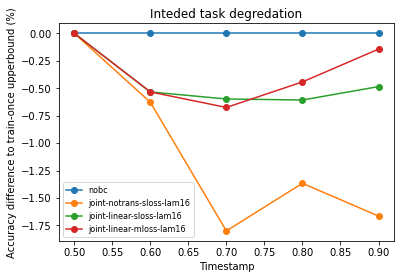

In [120]:
get_time_intended_performance_plot(dataset)

## Unintended Task degradation over time

Here we plot how the the performance of the model on the unintended task degrades over time. We plot the difference in performance of each model compared to fix-m0. The performance at each time step is the performance on the validation dataset associated with that timestep.

In [126]:
label_list = [
    'fix-m0',
     f'joint-notrans-sloss-lam{lam}',
     f'joint-linear-sloss-lam{lam}',
     f'joint-linear-mloss-lam{lam}',
]

def get_time_unintended_performance_plot(dataset):
    unintended_performance = []
    for label in label_list:
        label_performance = []
        task_perf = []
        for task in task_list:
            if 'activity' in task:
                continue
            tmp = torch.load(f'embevolve/unintended_tasks/result/code-release/{dataset}/{task}/{label}')
            task_perf.append(np.array(tmp)[:,1].mean())
        label_performance.append(np.mean(task_perf))
        
        task_perf = []
        for task in task_list:
            tmp = torch.load(f'embevolve/unintended_tasks/result/code-release/{dataset}/{task}/{label}')
            tmp = np.array(tmp)[:,2:]
            task_perf.append(tmp.mean(axis = 0))
        label_performance.extend(np.mean(task_perf, axis = 0))
        unintended_performance.append(np.array(label_performance))
    unintended_performance = np.array(unintended_performance)

    for ind, label in enumerate(label_list):
        plt.plot(sliced_time_list[1:-1], (unintended_performance[ind] - unintended_performance[0])*100, 'o-', label = label)
    plt.legend(fontsize = 8)
    plt.title(f'Unintended task over time')
    plt.xlabel('Timestamp')
    plt.ylabel('Accuracy difference to train-once upperbound (%)')

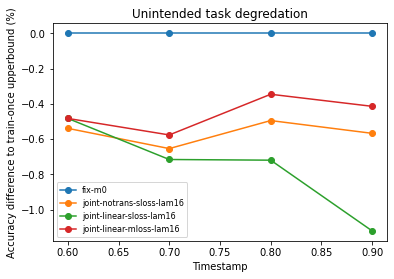

In [127]:
get_time_unintended_performance_plot(dataset)

## Function alignment error

We plot the function alignment error wiht time similar to unintended task performance. More error means lower performance.

In [130]:
label_list = [
    'fix-m0',
     f'joint-notrans-sloss-lam{lam}',
     f'joint-linear-sloss-lam{lam}',
     f'joint-linear-mloss-lam{lam}',
]

def get_time_alignment_performance_plot(dataset):
    func_align_error = []
    ref_embedding_list = torch.load(f'embevolve/intended_task/checkpoint/code-release/Amazon-Musical_Instruments/{label_list[0]}', map_location = "cpu")['best_embedding_list']
    for label in label_list:
        tmp = torch.load(f'embevolve/intended_task/checkpoint/code-release/Amazon-Musical_Instruments/{label}', map_location = "cpu")
        
        func_align_inf = []
        for ind, embeddings in enumerate(tmp['best_embedding_list']):
            func_align_inf.append(torch.mean(torch.sum((torch.vstack(embeddings)[:, :256] - torch.vstack(ref_embedding_list[ind]))**2, axis = 1) ** 0.5))
        func_align_error.append(np.array(func_align_inf))

    for ind, label in enumerate(label_list):
        plt.plot(sliced_time_list[:-1], (func_align_error[ind] - func_align_error[0]), 'o-', label = label)
    plt.legend(fontsize = 8)
    plt.title(f'Embedding alignment error over time')
    plt.xlabel('Time of evaluation')
    plt.ylabel('Embedding alignment error')

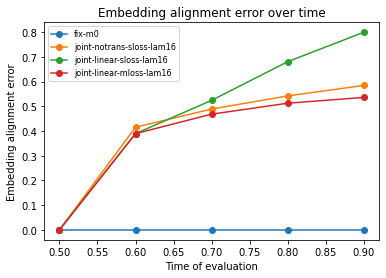

In [131]:
get_time_alignment_performance_plot(dataset)

## Unintended task performance by task

Here we plot how the performance of different unintended tasks change over time. We compare the performance of each task on the best model as compared to the fix-m0 model. Most of the tasks have similar behavior.

In [1]:
def get_unintended_task_performance_plot(dataset):
    task_perf = []
    for task in task_list:
        our_res = torch.load(f'embevolve/unintended_tasks/result/code-release/{dataset}/{task}/joint-linear-mloss-lam{lam}')
        keep_all_res = torch.load(f'embevolve/unintended_tasks/result/code-release/{dataset}/{task}/fix-m0')
        
        if 'activity' in task:
            our_res = np.array(our_res)[:, 2:].mean(axis = 0)
            keep_all_res = np.array(keep_all_res)[:, 2:].mean(axis = 0)
        else:
            our_res = np.array(our_res)[:, 1:].mean(axis = 0)
            keep_all_res = np.array(keep_all_res)[:, 1:].mean(axis = 0)
        task_perf.append((our_res - keep_all_res) * 100 / keep_all_res)

    for ind, task in enumerate(task_list):
        if 'activity' in task:
            plt.plot(sliced_time_list[2:-1], task_perf[ind], 'x-', label = task)
        else:
            plt.plot(sliced_time_list[1:-1], task_perf[ind], 'x-', label = task)
    plt.plot(sliced_time_list[1:-1], np.zeros(len(sliced_time_list[1:-1])), linestyle = '--', c = 'gray')
    plt.legend(fontsize = 8)
    plt.ylim([-1.5, 1.5])
    plt.title(f'Unintended task performance over time')
    plt.xlabel('Time of evaluation')
    plt.ylabel('Embedding alignment error')

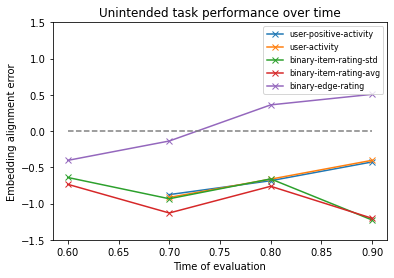

In [156]:
get_unintended_task_performance_plot(dataset)